# IonQ Continued: Rolling Beta Esitmation

In the previous notebook we set up a method to test the hypothesis that there was a correlation between IonQ publishing papers on arXiv about their research into quantum computing, and the returns on the IONQ ticker. We saw that initial anlaysis did not point to this being the case, but that there are potential robustness checks we could perform to ensure we are accurately getting the values we need to perform the analysis. In this notebook we will perform a similar analysis, but we will estimate our abnormal returns using a rolling regression

## Why Rolling Regression?

A stocks influence by the market is very much an evolving one; it is entirely circumstantial to the position the market is in as well as the position that the company is in. While we can approximate the relationship of a stock to the market ($\beta$) over long time windows, the more dynamic your estimation is the more closely one can understand the precise correlation at a given time. In the previous notebook we regrssed the returns of IONQ against ^GSPC over a four year period, and used the regression residuals to get our abnormal returns metric. How would this change if we made our regression more robust to more accurately capture the dynamics of the assets correlation to the overall market?

## Data

In [48]:
import pandas as pd
import yfinance as yf

stock_data = pd.read_pickle("../data/ionq_price_data.pkl")
arxiv_df = pd.read_pickle("../data/arxiv_pubs.pkl")
market_returns = pd.read_pickle("../data/market_returns_data.pkl")

## Analysis

Let's consider a 120 index window for this example:

In [50]:
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

window = 35

Y = stock_data['Close']['IONQ'].pct_change().fillna(0)
X = market_returns
X = sm.add_constant(X)

reg = RollingOLS(Y,X,window=window,expanding=True).fit()

alpha = reg.params['const'].fillna(method='bfill')
beta = reg.params['^GSPC'].fillna(method='bfill')

residual = Y - (X['^GSPC']*beta) - alpha
residual = residual[1:]
beta = beta[2:]
alpha = alpha[2:]
stock_data = stock_data[2:]

/Users/williamfriend/anaconda3/envs/qsig/lib/python3.13/site-packages/statsmodels/regression/rolling.py:255: RuntimeWarning: divide by zero encountered in scalar divide
  s2 = ssr / (nobs - tot_params)
/var/folders/z6/_3pyslnx09v4vxgrswzkct1h0000gn/T/ipykernel_78085/3010857994.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  alpha = reg.params['const'].fillna(method='bfill')
/var/folders/z6/_3pyslnx09v4vxgrswzkct1h0000gn/T/ipykernel_78085/3010857994.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  beta = reg.params['^GSPC'].fillna(method='bfill')


We can quickly visualize the regression residual (or the abnormal returns), as well as our regression parameters:

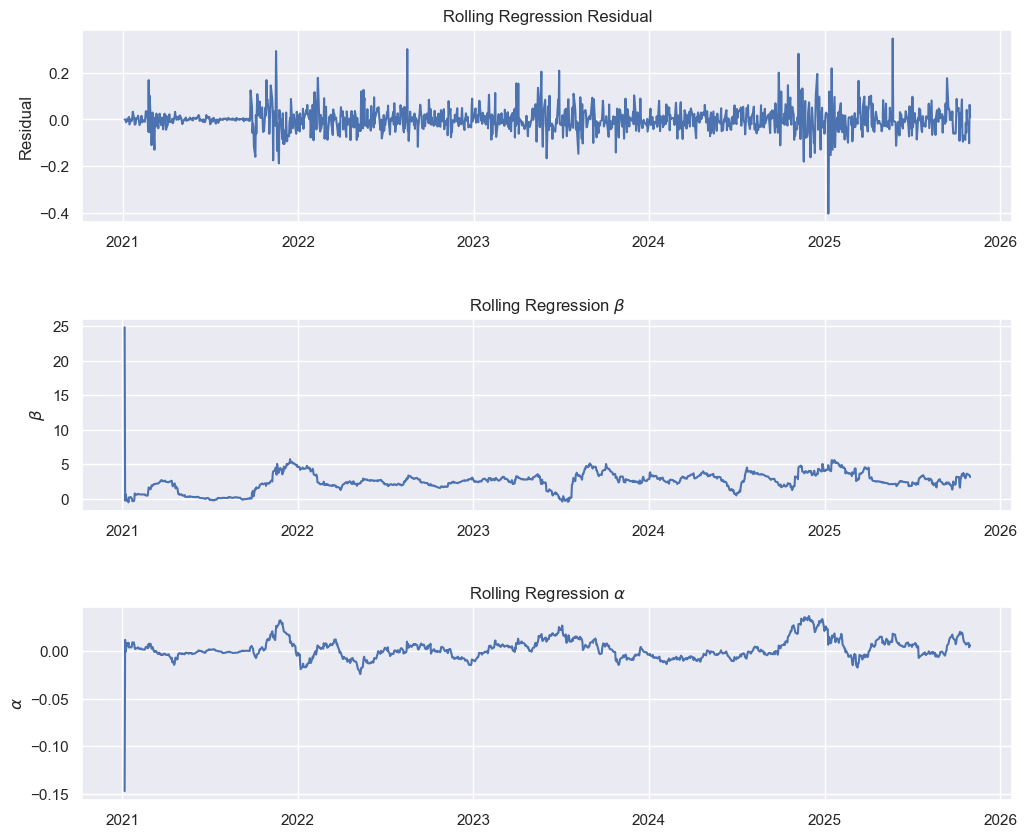

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

fig, ax = plt.subplots(3, 1,figsize=(12,10))
_ = ax[0].plot(residual)
_ = ax[0].set_ylabel("Residual")
_ = ax[0].set_title("Rolling Regression Residual")

_ = ax[1].plot(beta)
_ = ax[1].set_ylabel(r"$\beta$")
_ = ax[1].set_title(r"Rolling Regression $\beta$")

_ = ax[2].plot(alpha)
_ = ax[2].set_ylabel(r"$\alpha$")
_ = ax[2].set_title(r"Rolling Regression $\alpha$")

plt.subplots_adjust(wspace=0.3, hspace=0.5)

Now that we have our rolling abonormal returns, we can run our single-sample t-test just as we did in `01_IonQ_Start_Exploration.ipynb`, and plot the results:

In [52]:
import sys
sys.path.append('../')
from src.compute_car import compute_car

import scipy.stats as stats

windows = [i for i in range(0,36)]

t_stat_df = pd.DataFrame(index=windows)

for window in windows:
    cars = []
    for event_date in arxiv_df.index:
        if event_date in stock_data.index:
            idx = stock_data.index.get_loc(event_date)
            car = compute_car(residual, idx, window=window)
            cars.append(car)
    
    cars = pd.Series(cars)
    cars = cars.dropna()
    
    t_stat_df.loc[window,'Mean'] = cars.mean()
    t_stat_df.loc[window,'Std'] = cars.std()
    
    tstat, pval = stats.ttest_1samp(cars, 0.0)
    
    t_stat_df.loc[window,'t'] = tstat
    t_stat_df.loc[window,'p-value'] = pval

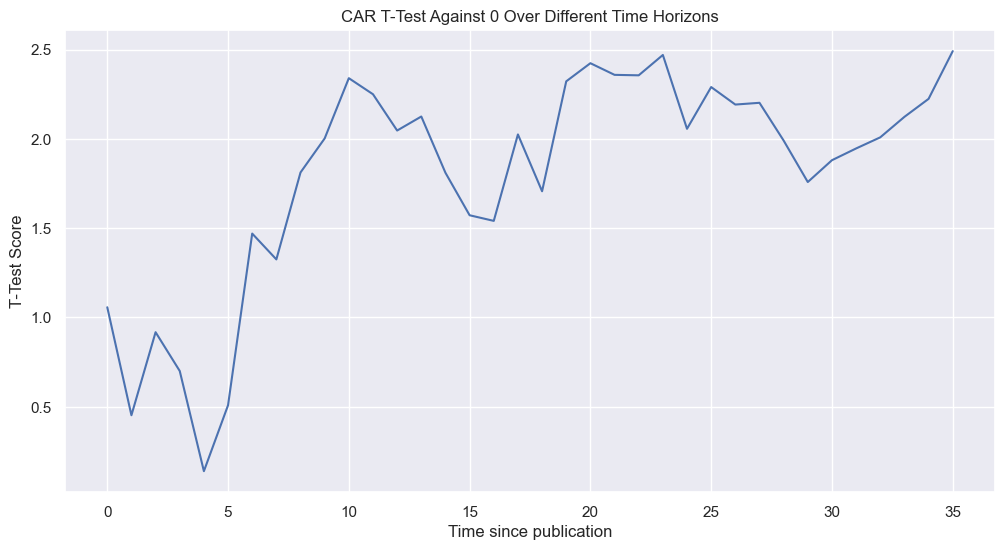

In [53]:
ax, fig = plt.subplots(figsize=(12,6))
_ = plt.plot(t_stat_df.index, t_stat_df['t'])
_ = plt.xlabel("Time since publication")
_ = plt.ylabel("T-Test Score")
_ = plt.title("CAR T-Test Against 0 Over Different Time Horizons")

From the above plot we can see that the results of our t-test seems to show slightly more significance at longer time periods, showing that there are potentially larger returns around 10-days out from the publication of a paper. This could very well be a general trend do to market conditions though, so we should test this over several windows with no publications and see if we get a similar test result. Before we move to that, though, lets quickly look at the p-values for each of these t-tests:

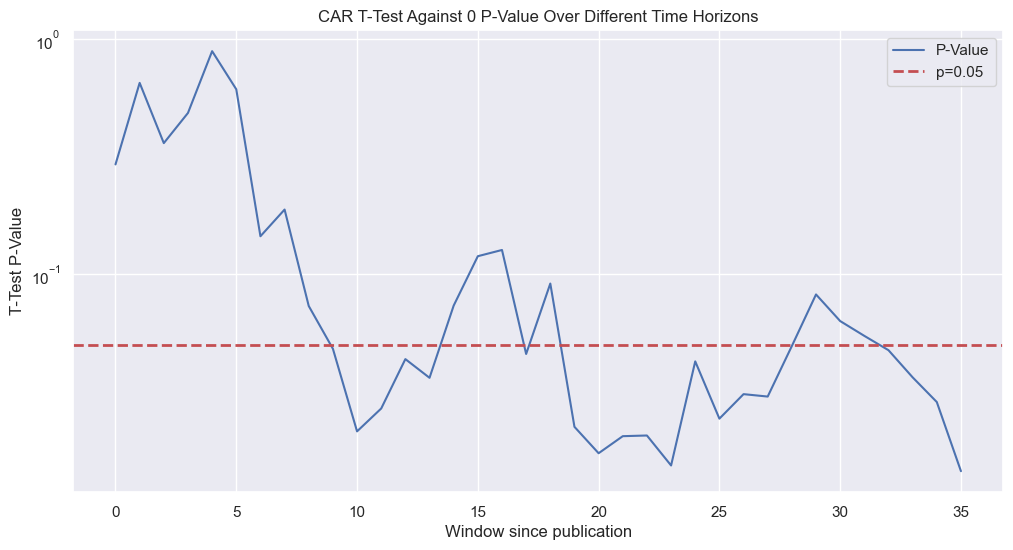

In [54]:
ax, fig = plt.subplots(figsize=(12,6))
_ = plt.semilogy(t_stat_df.index, t_stat_df['p-value'], label='P-Value')
_ = plt.axhline(y=0.05, color='r', linestyle='--', linewidth=2, label='p=0.05')
_ = plt.xlabel("Window since publication")
_ = plt.ylabel("T-Test P-Value")
_ = plt.title("CAR T-Test Against 0 P-Value Over Different Time Horizons")
_ = plt.legend()

We can see that after ~5-days, we have p-values below the 0.05 value line, which typically is denoted as the threshold of where things start to be considered statistically significant.

To see if this is truly unique, we take $n$ random sample dates (from dates that are +/- 10 days apart from a publication day), where $n$ is equal to the number of publication dates we analyzed, and perform the same analysis on them. We will repeat this process 1000 times, and aggregate the t-values for each window by taking the mean across the sample space, and compare the result for the random days to the publication event results:

In [55]:
n = len(arxiv_df)

filtered_dates = []
for idx in stock_data.index:
        if all(abs(idx - arxiv_df.index) > pd.Timedelta('10d')):
            filtered_dates.append(idx)
            
t_stat_random_df = pd.DataFrame(index=windows, columns=['t{}'.format(i) for i in range(1000)])
for i in range(1000):
    random_date_df = stock_data.loc[filtered_dates].sample(n)
    for j, window in enumerate(windows):
        cars = []
        for rand in random_date_df.index:
            idx = stock_data.index.get_loc(rand)
            car = compute_car(residual, idx, window=window)
            cars.append(car)

        cars = pd.Series(cars)
        cars = cars.dropna()

        tstat, pval = stats.ttest_1samp(cars, 0.0)

        t_stat_random_df.iloc[j,i] = tstat

First we can look at our event test and compare to the range of the random test results, to see if our event results fall within the random samples range:

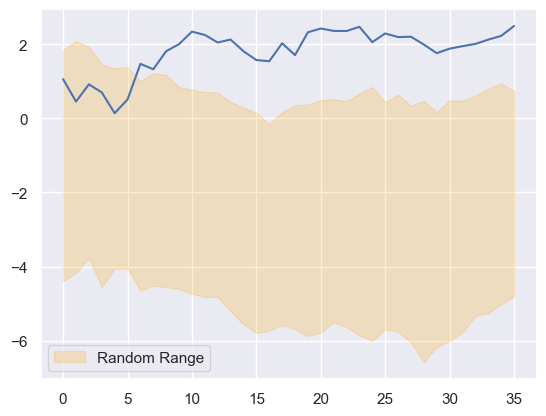

In [56]:
compare_tstat_df = pd.DataFrame({'Event T-Stat': t_stat_df['t'], 'Random T-Stat': t_stat_random_df.mean(axis=1)})
_ = plt.plot(windows, t_stat_df['t'])
plt.fill_between(windows, 
                 t_stat_random_df.min(axis=1).astype(float),
                 t_stat_random_df.max(axis=1).astype(float),
                 color='orange', alpha=0.2, label='Random Range')
plt.legend()
plt.show()

We can see that for windows of length greater than five, the publication dates CAR compared to 0 (t-test score) is outside the range of the random sampling's range of CAR compared to 0 (t-test score). We can also look at the mean score and the +/- 2$\sigma$ bands of the randle sample to see where our event driven results lie:

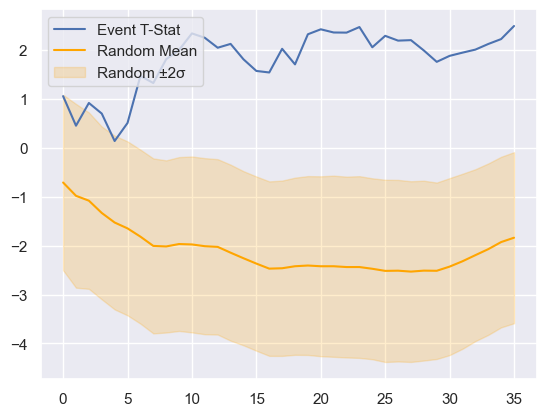

In [58]:
mean_random = t_stat_random_df.mean(axis=1).astype(float)
std_random = t_stat_random_df.std(axis=1).astype(float)

plt.plot(windows, t_stat_df['t'], label='Event T-Stat')
plt.plot(windows, mean_random, label='Random Mean', color='orange')
plt.fill_between(windows, mean_random - 2*std_random, mean_random + 2*std_random,
                 color='orange', alpha=0.2, label='Random ±2σ')
plt.legend()
plt.show()

From the above results, we can see a significant difference between the results of the random sampling test and the test with the event (publication data). Consistent with the range plot above, we see that for windows of length greater than five, the event drive results lie outside of two standard deviations from the mean t-stat for the random samples.

Finally, as a robustness check, we can not filter our dates, so that our random sampling is included. We should expect to see the mean of the random sample t-stat shift up from the plot above:

In [ ]:
n = len(arxiv_df)
           
t_stat_random_df = pd.DataFrame(index=windows, columns=['t{}'.format(i) for i in range(1000)])
for i in range(1000):
    random_date_df = stock_data.sample(n)
    for j, window in enumerate(windows):
        cars = []
        for rand in random_date_df.index:
            idx = stock_data.index.get_loc(rand)
            car = compute_car(residual, idx, window=window)
            cars.append(car)

        cars = pd.Series(cars)
        cars = cars.dropna()

        tstat, pval = stats.ttest_1samp(cars, 0.0)

        t_stat_random_df.iloc[j,i] = tstat

In [ ]:
mean_random = t_stat_random_df.mean(axis=1).astype(float)
std_random = t_stat_random_df.std(axis=1).astype(float)

plt.plot(windows, t_stat_df['t'], label='Event T-Stat')
plt.plot(windows, mean_random, label='Random Mean', color='orange')
plt.fill_between(windows, mean_random - 2*std_random, mean_random + 2*std_random,
                 color='orange', alpha=0.2, label='Random ±2σ')
plt.legend()
plt.show()

We can see that with the inclusion of the publication dates, there is a significant shift in the mean test result. Our soley event based dataset is now mostly within 2$\sigma$ of the mean of the random test-score. This shift is what we would expect now that we are including the seemingly significant publication dates in our example.

## Discussion I

The above analysis indicates that including a more dynamic measure of abnormal returns by using a rolling regression has brought out a potential correlation. We tested this result by randomly sampling the same amount of dates from out dataset, exluding days that fell within +/- 10 days of a publication event, to see if the same results could be generated from random days. The result showed that the event driven results lay outside two standard deviations from the aggregated t-test statistics of 1000 random sampling runs, hinting further at a pontential relationship.

From the analysis above, we ran a simple single-sample t-test. A single t-test tests the null hypothesis that the expected value of a sample is equal to the provided population mean. In our case, our null hypothesis is the the CAR of the publication dates for varying windows should be centered around the expected population value of 0. Why do we compare to 0? Because if the event did not effect the stock, and in our isolated world the only factor is the market, than the expected returns - the actual returns (or our residual in our regression) should be 0, since we are not adding additional information into the market.

Another line of thought that we will explore now is, rather than treating the sample as stand alone, we will run a 2-sample t-test, comparing the mean of our event based sample to the mean of the the random sample. This should yield a similar result to above if our tests are to be believed, but let us conduct this second test.

## Analysis II